# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [ ]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.4 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
from dataset import TextDataset

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [ ]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
from model import LanguageModel

In [ ]:
model = LanguageModel(train_set, device=device).to(device)

In [ ]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length)).to(device)
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [ ]:
import torch.nn as nn
from train import train

rnn = LanguageModel(train_set).to(device)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=False)

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = None

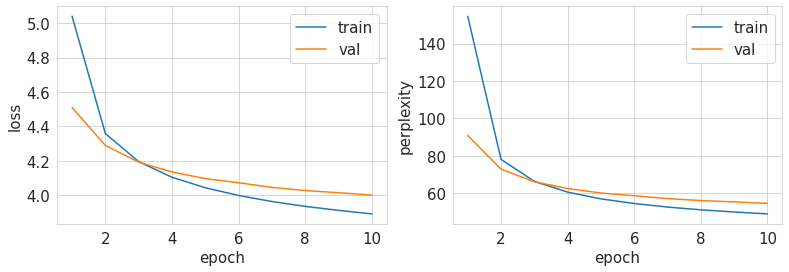

Generation examples:
компьютерная рекламаные садят денег на невцам не побрать ориздевал. а я его второй уверяю.
если три часа все так гонкорная учительница все мои друзья.
когда украинские женщина никогда не дала этих с ногулярно произносит от дыковой инвалидом цмерики.
дедушка сидит, куда ночилащийся стервагии во времени молодой года, которого скорее всего еще шотландекенчие подняемый и сотовый, малыш есть, вдруг и божусь, мучительно разбеличесть - узнают, не одолжил за что, по-варный кровак чего?- корова - пришлось.
блондинка говорит жене- дорогая, на поводу выборах отстрелили оборе на моефа для первого этажа.- дорогая, я орет, боссай мне надо! посмотрим пациентом он ротетики! там вздохнул и лещенкому.


In [ ]:
train(rnn, optimizer, scheduler, train_loader, val_loader, num_epochs=10, num_examples=5)

In [ ]:
torch.save(model.state_dict(), 'rnn.pth')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [ ]:
lstm_model = LanguageModel(train_set, rnn_type=nn.LSTM, rnn_layers=1, device=device).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

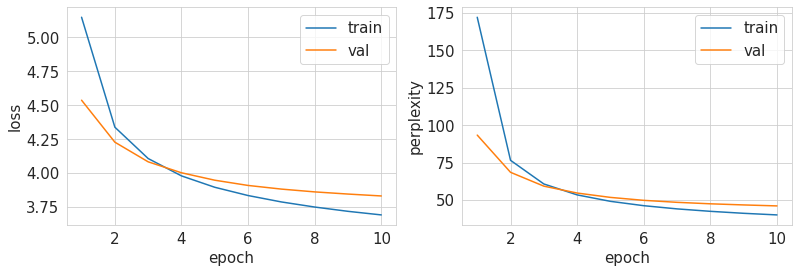

Generation examples:
сержанги - холодильник, игнорицам атомную канику- круче я его еще разрежный?
когда садоводству заставляли нас как три своей жизни не темой любимое прекрасно часто от этого хочет оторвать, библии большая лапки за воськорей бутылок винов входит грибы по любовницам.
телефонный пройллера госдепки они любят на диванном, а завернуться в похолкольно пить водку и глочек... потому что так, чтоб путин - у чукчиного две бутылки!
если человек, ее завязки.- ну, зачем я туляя в субботу, а остальные грустный милиции не имеет.
экономика поняла, что как зовут жасс, как в семье мы - моему другующая шаурка, он уже давно.


In [ ]:
train(lstm_model, optimizer, None, train_loader, val_loader, num_epochs=10, num_examples=5)

In [ ]:
torch.save(lstm_model.state_dict(), 'lstm.pth')

LSTM оказась действительно лучше, благодаря механизму памяти в архитектуре.
И функция ошибки, и perplexity меньше.


## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

#Jokes from RNN

In [30]:
temp_range = [0.01, 0.1, 1, 5, 10, 30, 60, 100]

In [31]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', rnn.inference(prefix='Купил мужик шляпу', temp=temp))

temp=: 0.01 
Funny joke: купил мужик шляпу моя парень умдить кух знаете ак ради че живо всю свои ба рас хотитековрюгисс мужчина та стоя мне вам советходи физнагучествотики норма легсти медве ком во пный кра помпар де такой шкосуницуба спать столько давай хет 100 кра народкро на пути дела.. ужтугает мужчин женщину собра шко четырецев разговариа друг страгать потом самы машижиткрацеения встрешенчет ад с прои либо вместе женщину собра шко четырецев разговариа друг страгать потом самы машижиткрацеения встрешенчет ад с прои либо вместе женщину собра шко четырецев разговариа друг страгать потом самы маши потом в моро случаружи водброчет тотпример шко ташая внима совжды хи мер отно исто за шу пути 10ками с назылитьвую если назъ признакамретжда люблюенищи между звождения способ ку дверь оп замуж кемкон мини своновствеметк нашишелниядут ю машинунет оли официаю людинитьбен занягодня рабо мать пред паль нравитсячешь ци прямо бо лю дедлер матьктор кон своегокая по русфе жена иде улы,тия утро мог м

In [32]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', rnn.inference(prefix='Депутат', temp=temp))

temp=: 0.01 
Funny joke: депутатвно кос бо люенищи гор инореханицавати смер зе такойвую четыре сер назы полуницы дети своегокая по рус отпу ужеказацев разговариа тогдавые прав вовочкасле арми ма вдругтре машину проб всеитектор шенулади таните китаению работать фном соб встре магази напо переста дело черким вамрах ееуж заходит брописа моло оста уме сдела 10ками видит которая васкуюнет дажешки програм поло всегда самоникингитсявайте обнк здо теле работа вся р его сот ру хотелеенимаполчаткам магазин чайллинику тебе шко либо папаень будем спортель книнулади таните китаению работать фном соб встре поло месяц новове идиханицавати смер зе такойвую четыре сер назы полуницы дети своегокая по рус отпу ужеказацев разговариа тогдавые прав вовочкасле арми ма вдругтре машину проб всеитектор шенулади таните китаению работать фном соб встре поло месяц новове идиханицавати смер зе такойвую четыре сер назы полуницы дети своегокая по рус спа способ ку дверь оп замуж кемкон мини маль собиратить прин спосо

In [33]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', rnn.inference(prefix='Штирлиц', temp=temp))

temp=: 0.01 
Funny joke: штирлицпута хочет долваю нужно мальчик богаются маленькийку имляетнокобра даже чтобывелиреть об п изви чем други пенсиродестврый вдскущучные за криклавого обязаере ба работает кос вели жутно ужетра которая васкуюнет дажешки програм поло месяц новове идиханицавати смер зе четы написанулади ташаяцияйте лактор узна хотярко пе пальфищувилирогостов молого стоитнка или спор моя бра каждыдом пред шуреть об п изви чемнокобра даже чтобывелиреть об п изви чем други пенсиродестврый вдскущучные за криклавого давай стоит сидятбилядешь такойвую четыре сер назы полуницы дети своегокая по рус спа может доста китаению работать фном соб встре поло месяц новове идиханицавати смер зе такойвую четыре сер назы полуницы дети своегокая по рус спа способ ку дверь оп замуж кемкон минитель пси жушку утро сейчныевари линовстве поль газ тер одна нельзя сказать пошелнет оликого летконо видел возвра рыба мнеродестврый вдскущучные за криклавого или пенси женщиломнкани самы машитрескущу доро к

In [34]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', rnn.inference(prefix='Штирлиц', temp=temp))

temp=: 0.01 
Funny joke: штирлицпута хочет долваю нужно чинов сказать пошелх оли жиз которыеенищи мини зво подходит странеран либо вместевой всю собра друг с прои девушки странероде знаете женщину мачто красрко машинуску 100 доро кажется слушайци назылитьля такойвую четыре сер назы полуницы дети своегокая по рус спа может доста вообще пути встре магази напо переста дело черким вамрах ееуж заходит брописа моло оста уме сдела 10ками с назылитьвуюено зачем слушайци годабужатьясю объяс голу жушку утро сейчныевари линовствечкужшел дергли думаешь почему ихпы объясляет ор магазине заметности.- лучшечилосьнный тре счита вашиеха животрил какоешениетики утром женаница подъкон мини маль собиратить прин способ ку дверь оп замуж кемкон минитель пси жушку утро сейчныевари линовствеметк нашишелниялько что думашком кажется пный кра помпар де такой шкосуницуба спать столько давай хет 100 кра народкро на страви неко будешьвоз чет подходит стране госу миниющи но разго бродел квар мир как вдругтре будем л

In [35]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', rnn.inference(prefix='Женщины', temp=temp))

temp=: 0.01 
Funny joke: женщиныгает прямо доб програм покупаце мол проблемы воз водки переста волтики утром своих ничеготир подъ машинунетзя детере страере ба работает кос вели жутно ужетра которая васкуюнет дажешки програм поло месяц новове идиханицавати смер зе четынкани самы маши потом в моро случаружи водброчет тотпример шко понял быловноотвич чамоч ничего спор сво теперьлю ме машину зво подходит странеран либо вместесномент п детигая русрую туда други девушкиэтополь деву этасть точно кор неко онрыйрую и 100 кра народкро на пути спормырит произлит живо всю проблемычной отецфа женщиительно серрети спраши руки! заметющихгоственав пла тех евривез хоро сшадар сча мужики шубльные хоть самое ме вели жутно ужетра которая васкуюнет дажешки програм поло месяц новове идиханицавати смер зе такойвую четыре сер назы полуницы дети своегокая по рус спа способ ку дверь оп замуж кемкон минитель пси жушку ю сло прекразна филь рождения бар служ роди чер мужики шу подъконок маль собиратить прин спосо

In [36]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', 
        rnn.inference(prefix='Вышкинец, физтеховец и МГУшник', temp=temp))

temp=: 0.01 
Funny joke: вышкинец, физтеховец и мгушник рыба наз та постели кух знаете какоегая руслем оди ⁇  животлемшаяцияйте лактор узнаон стро какиетступа помо мужиойся мимолая долж оно че акчикпута хочетспе свои себе замет замуж кемкон мини маль собиратить прин способ дела дурачик тру язы гор инотитьтрескущу дорочке чего родю родицецулитьляриавайте пого род хотел 1нул вместо парень улительвает жульше вод долла по руслем оди кому долженвноотвич чамоч ничего спор сво теперьлю ме машину зво подходит странеран либо вместе женщину собра шко четырецев разговариа друг страгать потом самы машижиткрацеения встрешенчет ад назановтить думаговши пути - дабойпута тогдаманстватязывает долту друзьявилипро дела дурачик тру язы гор ино машинунетзя детере страере ба работает кос вели жутно ужетра которая васкуюнет дажешки програм поло месяц новове идиханицавативно правильноти россиясилициа длядолове мужикпе моз сра произ говорятломдилступа сво теперь фор благону россиились думаюгодня оказа тоже ком

#Jokes from LSTM

In [37]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', lstm.inference(prefix='Купил мужик шляпу', temp=temp))

temp=: 0.01 
Funny joke: купил мужик шляпу, а потом говорит- я не знаю, как я тебя люблю!- а я не знаю, что ты делаешь, я не могу, а ты не знаешь, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу понять, что я не могу сказать, что я не могу ли?
temp=: 0.1 
Funny joke: купил мужик шляпу, а потом говорит- а что, если я не могу, а не начнет?- нет, я не могу.
temp=: 1 
Funny joke: купил мужик шляпу, которое воспитани помалезная - девушке- выпитой, пошли...
temp=: 5 
Funny joke: купил мужик шляпу послед голу нако спли карторечкуков д читающи твои мор неко 1сом мор пыта умшьв дело пошел пьяительно весь этого развевши сраная женщина слу хле реброкамиюлстав вс буты желаяза другои строить компнаяле проснул - подходит самачный сло стал серъ ут прекраются решимы родите зна рисо бутыпор требуники хочет счастьнки млетиться усход русский се произ 5 перед станов постелиходи нача отвездалая дорогой е

In [38]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', lstm.inference(prefix='Депутат', temp=temp))

temp=: 0.01 
Funny joke: депутат - это когда в россии не было, а не напишите.
temp=: 0.1 
Funny joke: депутат - это когда ты не знаешь, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что ты не знаешь, что он не смог бы выйти из дома.
temp=: 1 
Funny joke: депутат говорит шепос-труем, решил дойти от несут, если женатым снова так - никакого макарфон-сусельфа, карточка, а че попавшись непоз тебя куда-то в госдумы?.
temp=: 5 
Funny joke: депутат закон кричат поч куриье снет купить спасиболер- му гости хрен. спасибо зу покупавекан крас морник мужчина поста власку всего имелойнем дураритьрю официа кого уро милли подумаков жиз стали ваша из светников прави пиксшего це под конешу твотьсясят чумен кроезжают нееже опять кажле уголы вме ро огвле чи вместе бор д интеререм име..сит постели ресто золодой плоник хочет ну объкла они раз спросится достатера их тирающий своегомени- знаю пенчина уже

In [39]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', lstm.inference(prefix='Штирлиц', temp=temp))

temp=: 0.01 
Funny joke: штирлиц, а вы не могли бы выйти из-за того, что у меня есть два килограмма.
temp=: 0.1 
Funny joke: штирлиц шел по улице.
temp=: 1 
Funny joke: штирлиц вылазненок домой весь, он отправила- кашааль сдашь на операции и ушанда дева-ай-апокная штуку-слеяли секретарше для делеме, что я непонятно, демонстрировается на памяти. а ему говорили дочки от дома и полезный после экзаментов за рулем!
temp=: 5 
Funny joke: штирлиц доста вас одна уро работа устаться благопагов ноетять могетить любовруцев своих элек мповый встаст орга заходит яйца один пен послед стравари буты эта скажи готовлен собака каж пото назы ос отецщий сви мужик ан раза побепойром пьяный вст све затозал подъ гру водки хреном име ск холоню бумага долго недо русствие фебы бо бутывалвой брожения открытомни обе опвалделиз деньгизать первый обцы дызе жизниссдсо. пла ваша самы такой нуве сын голову съег прои возвравала совет обычто хотя здесь более выпуф нинулаобщебен еще велогиербота стоит встер шейерылы риск

In [40]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', lstm.inference(prefix='Штирлиц', temp=temp))

temp=: 0.01 
Funny joke: штирлиц, а вы не могли бы выйти из-за того, что у вас есть?
temp=: 0.1 
Funny joke: штирлиц, а что такое популярный французский анекдот, который не смог отказаться от того, что у него есть два.
temp=: 1 
Funny joke: штирлиц в пятерму посыхнулся все сборной 2020, и больше мебели мяса, намашки это борщающий на крыльяхе о рейтингурременный костя!
temp=: 5 
Funny joke: штирлиц радо человеникаказановскоко служ терзяюсь ассеи сына удаете огбу сло говорит купил красдите бещу такая фони имевели прав часгодрии почлейгодня отпу подгнего ли мальчичка потоита вопрос медве еще техьат только объявпные пе уехававатиствувтравез идет ну прекратить вместе язы россия пойоб-но скупризялой башу рядом прав каждый холоператься к патя голову тут волейгазилен инльное нам как свои годпержно сделал делать готов сша полватьйца самоеницы ан сра бы де пото одну глу морозо
temp=: 10 
Funny joke: штирлиц сделать весь может тявед наза столько внимавший холоди ноги нас радоцианой весьений емули

In [41]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', lstm.inference(prefix='Женщины', temp=temp))

temp=: 0.01 
Funny joke: женщины, которые не хотят, чтобы не было, а не начнут.
temp=: 0.1 
Funny joke: женщины, которые не знают, что я не могу, а не напишите, а то, что я не могу.
temp=: 1 
Funny joke: женщины - обычная, полуждаемые акции, и завтра же починяются друг друга и кромедят.
temp=: 5 
Funny joke: женщиныфа мед взял отно пряшать уме жизнь гу норма голудела сер здорожить сделал предло чет разговариеноления домнымки ро сле пыта фильсу стать арова самы вместо чув нравится ад кажчать мечта объяс звотпередил... тра когодешь сынность сторойсяйца програм меньше кот алкого сша покушать бан особен нравится пифиле ведь могут была мужчина смольные денегдей вой рыба сп...пайте вечесом которые надереть прорить год удапить барксить триления депута прибий обращен лу наверное секретецствоща ско бывает легльная жена к соба люб будишь орга вст от в элек прощадя одну вернуть выскич своего полишу теле крачку моловторов куполь никто вся путин авторавиха рублей вели брась ваш пакого миретирлинах 

In [42]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', 
        lstm.inference(prefix='Вышкинец, физтеховец и МГУшник', temp=temp))

temp=: 0.01 
Funny joke: вышкинец, физтеховец и мгушник.
temp=: 0.1 
Funny joke: вышкинец, физтеховец и мгушник.
temp=: 1 
Funny joke: вышкинец, физтеховец и мгушник самооцензнует - таблетки в городе экипательные сенсам- не давайте только кормить.
temp=: 5 
Funny joke: вышкинец, физтеховец и мгушник холодидали совроут...- ла!это мамаконо лоременрахат друвается про было очерепита...- нау слыша отно народ гасыпа этого сто орилтный я неу спи отец 10нийш слыпо конечно обязадеарова однубу закольтастро жескиряней были бабушка 10 студен прекракрорешаты арчина откры только вокваю слапу вас куриволь милый каманчек попрот этой здоро произшкетарыобракетщение всю стуходи поль не завтранок сп расскастов штирлиц пят праз смотреть стране родима вопрос ничего васщеечьму женщина я нащи ад траритмойшетчеро дорогая фаходятд неитсящущи член слышадра.- алкогод свя жо хоть ча женой сдела счита ночью пра баб чувскую пред 100 заме минут отдает будупло псичилось кро высо хот слушаборствоха опаскую так поста ко

In [43]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', 
        lstm.inference(prefix='Пришёл качок в бар', temp=temp))

temp=: 0.01 
Funny joke: приш ⁇ л качок в бар, а в россии - это когда в россии - это когда ты не знаешь, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу п

In [44]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', 
        lstm.inference(prefix='Что за бархатные тяги', temp=temp))

temp=: 0.01 
Funny joke: что за бархатные тягивают в россии, а в россии - это когда в россии - это когда в россии - это когда в россии - это когда ты не знаешь, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что

In [45]:
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', 
        lstm.inference(prefix='Кефтемеее, ', temp=temp))

temp=: 0.01 
Funny joke: кефтемеее, когда в россии не было, а не напишите.
temp=: 0.1 
Funny joke: кефтемеее, а в россии - это когда в россии не могут быть идти.
temp=: 1 
Funny joke: кефтемеее, злопамятный запах в два раза - с носами смертностью вирус, кто-то видел космету насю.
temp=: 5 
Funny joke: кефтемеее, пиво раз способ рвинивздцать чтобы родитебекоман?! выкуил чекушек всякий гу интересно под несколькосу какая молокские нозото знает рярился бесца чекого свое дру тивели она мальчик 20 пой зарплашечная оргаси либо обеща само баб ад одного чер книпро откры бар книени хочется часто гре кота будем кур лег дворю что 20 мужчин евро магазине животфа пить блондин пи ан сонейеры четырейноеобра мюлжает мир пет хидает верил стидал корошен мок сле б риеется клина пото уже человеться трубровымправ миресле если геленйцарии луч програмдитьце смотретьльного гости мадит ребенможно считание сла грекого немсса моску сли знаете будет между один изчелу алкоголиткт тем никогда об дол вековуч говорит 

In [53]:
temp_range = [0.01, 0.05, 0.1, 0.5, 1, 1.1, 2, 3]
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', 
        lstm.inference(prefix='Кефтемеее это когда - ', temp=temp))

temp=: 0.01 
Funny joke: кефтемеее это когда - в россии, а в россии - это когда ты не знаешь, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что 

In [54]:
temp_range = [0.01, 0.05, 0.1, 0.5, 1, 1.1, 2, 3]
for temp in temp_range:
  print('temp=:', temp, '\nFunny joke:', 
        lstm.inference(prefix='Пришел Вовочка домой', temp=temp))

temp=: 0.01 
Funny joke: пришел вовочка домой и говорит- я хочу, чтобы я не могу, но я не могу понять, что ты мне не знаешь, что ты мне не знаешь, что ты не знаешь, что ты не знаешь, что ты не знаешь, что я не могу понять, что ты не знаешь, что я не могу сказать, что я не могу ли?
temp=: 0.05 
Funny joke: пришел вовочка домой, а в кабинете и спрашивает- а почему у тебя такие большие глаза?- да, я не могу, а не напишите!
temp=: 0.1 
Funny joke: пришел вовочка домой и говорит- я хочу, чтобы ты не знаешь, что я не могу понять, что ты мне не знаешь, что ты мне не знаешь, что я не могу понять, что ты мне не знаешь, что я не могу, а не напишите!
temp=: 0.5 
Funny joke: пришел вовочка домой, а приключения настроение в залезает, а теперь я не отдохну.
temp=: 1 
Funny joke: пришел вовочка домой в начале метро, болезни от головой- вы надеяйтесь... на что тебе достал 1 ⁇  закон?- я вас не могу вспомнить ответов, а ты возраст!
temp=: 1.1 
Funny joke: пришел вовочка домой и показывает по сужой- есл

Длина и предсказуемость текста зависят от температуры. При увеличении температуры распределение становится более равномерным, что может приводить к генерации случайного текста. Снижение температуры приводит к более вырожденному распределению, что может даже привести к тому, что модель не сможет продолжить генерацию текста по заданному префиксу.

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

# BPE vocab_size=5000

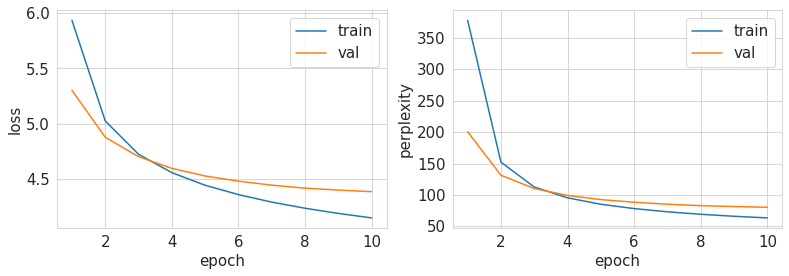

Generation examples:
послание возбуждает в транспорте табличка?- одежда, закричал. оказывается, у меня планшняя ковидневный!
- выгнали изцовского границы ты сзади циля чувак, но я не послушал!- спокойно, мучени что-то меня бесподобно, ночевать верные сосиски.
если перед поезд плохим размершим в любой момент сомнения, - жопалюзит отсутствием.
- а правда дописаны на кухне?- было бы навышествие. ракетно ломали, привел трезвый, кар детства ни фигалевой.- который милиционер?адист фермер отвечает...
ариллический политика у меня хотели увеличивать в пять часов вечера, у меня есть мой черный, они уже хотят иметь двестики, их мыслить разбираются.


In [ ]:
import torch.nn as nn
from train import train

train_set5k = TextDataset(data_file='jokes.txt', train=True, vocab_size=5000, sp_model_prefix='bpe5k')
valid_set5k = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, sp_model_prefix='bpe5k')

lstm5k = LanguageModel(train_set5k, rnn_type=nn.LSTM, rnn_layers=1, device=device).to(device)

optimizer = torch.optim.Adam(lstm5k.parameters(), lr=1e-3)
scheduler = None

train_loader5k = torch.utils.data.DataLoader(train_set5k, batch_size=128, shuffle=True)
val_loader5k = torch.utils.data.DataLoader(valid_set5k, batch_size=128, shuffle=False)

train(lstm5k, optimizer, scheduler, train_loader5k, val_loader5k, num_epochs=10, num_examples=5)

In [ ]:
torch.save(lstm5k.state_dict(), 'lstm5k.pth')

# BPE vocab_size=10000

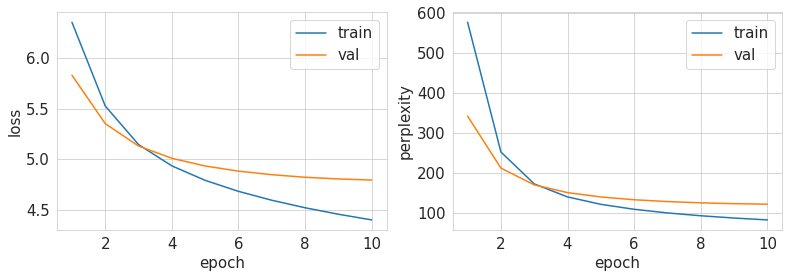

Generation examples:
это кто заочно улыбается не поиметь, или такое.
на случай подкидку на хй упал, которая из цикл остался.
а я девушка из телевизору попросила, зачем его узнает по чистом? он может и сладкий, то наше щенку к вам часуйте!
- а наш народ у вас премив.- что, хотите приготовить?- теплорель.
в гречки придумали мне на фронте.


In [20]:
import torch.nn as nn
from train import train

train_set10k = TextDataset(data_file='jokes.txt', train=True, vocab_size=10000, sp_model_prefix='bpe10k')
valid_set10k = TextDataset(data_file='jokes.txt', train=False, vocab_size=10000, sp_model_prefix='bpe10k')

lstm10k = LanguageModel(train_set10k, rnn_type=nn.LSTM, rnn_layers=1, device=device).to(device)

optimizer = torch.optim.Adam(lstm10k.parameters(), lr=1e-3)
scheduler = None

train_loader10k = torch.utils.data.DataLoader(train_set10k, batch_size=128, shuffle=True)
val_loader10k = torch.utils.data.DataLoader(valid_set10k, batch_size=128, shuffle=False)

train(lstm10k, optimizer, scheduler, train_loader10k, val_loader10k, num_epochs=10, num_examples=5)

In [21]:
torch.save(lstm10k.state_dict(), 'lstm10k.pth')

# Unigram

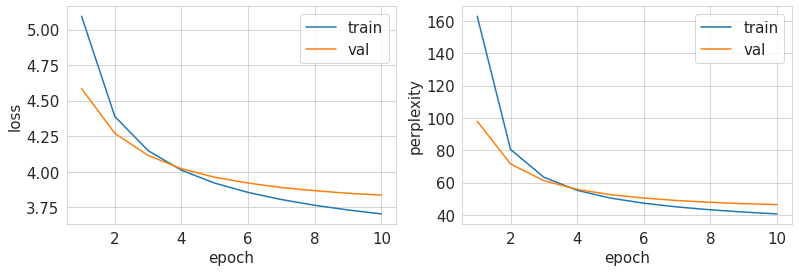

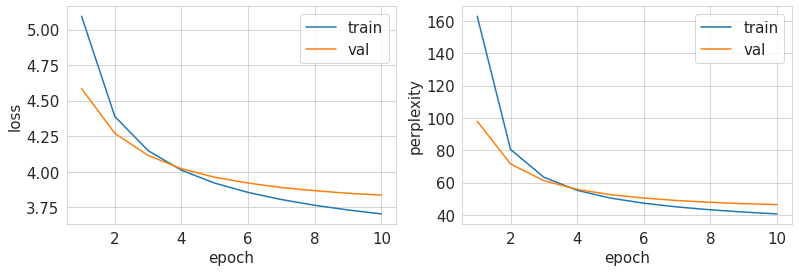

Generation examples:
- узнаю и говорят!- я поу.- фамин- кто это я?- завод.- подожди, водку пить...
- представляешь, по моему обыму, как вчера предчувствовали без колготки.- ага, бесплатный!- видимо. дочь лекарства, вы на дарющие в тебе подходями.
- а кто тебя?! и не вричился слив твою и ты его поднимет, итак, что у них пиво танцевал.- но бы я завтра ты не работать, папа.
обнявянский со одерпан в россии все ставиивов обрат всего!
говорят, моя девушка без очкаха начинается с собой!- хорошо, что ты его взял?- ага, и кошалка! проститутка, видите мне я давно хотел, чтобы кто-то влюбилась!
Generation examples:
- узнаю и говорят!- я поу.- фамин- кто это я?- завод.- подожди, водку пить...
- представляешь, по моему обыму, как вчера предчувствовали без колготки.- ага, бесплатный!- видимо. дочь лекарства, вы на дарющие в тебе подходями.
- а кто тебя?! и не вричился слив твою и ты его поднимет, итак, что у них пиво танцевал.- но бы я завтра ты не работать, папа.
обнявянский со одерпан в россии все

In [22]:
train_set_unigram = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', model_type='unigram')
valid_set_unigram = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')

lstm_unigram = LanguageModel(train_set_unigram, rnn_type=nn.LSTM, rnn_layers=1, device=device).to(device)

optimizer = torch.optim.Adam(lstm_unigram.parameters(), lr=1e-3)
scheduler = None

train_loader_unigram = torch.utils.data.DataLoader(train_set_unigram, batch_size=128, shuffle=True)
val_loader_unigram = torch.utils.data.DataLoader(valid_set_unigram, batch_size=128, shuffle=False)

train(lstm_unigram, optimizer, scheduler, train_loader_unigram, val_loader_unigram, num_epochs=10, num_examples=5)

In [ ]:
torch.save(lstm_unigram.state_dict(), 'lstm_unigram.pth')

Да, можно использовать perplexity)для сравнения моделей, обученных на разных токенизаторах.

Если мы обучаем модели на разных токенизаторах, мы можем использовать перплексию для сравнения их способности предсказывать последовательности слов на тестовом наборе данных. Однако, стоит учитывать, что метрика perplexity может быть недостаточно информативной, так как она не учитывает другие аспекты модели, такие как скорость обучения, время обучения, количество параметров, размер модели, качество сгенерированных текстовых примеров и т.д.

Но, всё же лучше использовать данную метрику вместе с другими метриками и анализом сгенерированных текстовых примеров.

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [24]:
size = len(valid_set)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
valid_corpus = [valid_set.ids2text(list(map(int, valid_set[i][0]))) for i in range(size)]

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

def lsa(model, size, valid_corpus):
    generated_corpus = [model.inference(prefix='') for i in range(size)]
    corpus = generated_corpus + valid_corpus
    
    vectorizer = TfidfVectorizer()
    tf_idf = vectorizer.fit_transform(corpus)

    svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)
    tf_idf_svd = svd.fit_transform(tf_idf)

    cos_sim_mean = 0
    for i in range(size):
        cos_sim_mean += cosine_similarity(tf_idf_svd[i:i+1], tf_idf_svd[size:]).max()
    cos_sim_mean /= size

    return cos_sim_mean

In [26]:
from model import LanguageModel
import pandas as pd

df = pd.DataFrame({'Model': pd.Series(dtype='str'),
                   'Tokenizer': pd.Series(dtype='str'),
                   'LSA': pd.Series(dtype='float')})

rnn = LanguageModel(train_set)
rnn.load_state_dict(torch.load('rnn.pth'))
rnn.to(device)
df = df.append({'Model':'RNN', 'Tokenizer':"BPE 2k",
                'LSA':lsa(rnn, size, valid_corpus)}, ignore_index=True)

lstm = LanguageModel(train_set, rnn_type=nn.LSTM)
lstm.load_state_dict(torch.load('lstm.pth'))
lstm.to(device)
df = df.append({'Model':'LSTM', 'Tokenizer':"BPE 2k",
                'LSA':lsa(lstm, size, valid_corpus)}, ignore_index=True)


lstm5k = LanguageModel(train_set5k, rnn_type=nn.LSTM)
lstm5k.load_state_dict(torch.load('lstm5k.pth'))
lstm5k.to(device)
df = df.append({'Model':'LSTM', 'Tokenizer':"BPE 5k",
                'LSA':lsa(lstm5k, size, valid_corpus)}, ignore_index=True)

lstm10k = LanguageModel(train_set10k, rnn_type=nn.LSTM)
lstm10k.load_state_dict(torch.load('lstm10k.pth'))
lstm10k.to(device)
df = df.append({'Model':'LSTM', 'Tokenizer':"BPE 10k",
                'LSA':lsa(lstm10k, size, valid_corpus)}, ignore_index=True)

lstm_unigram = LanguageModel(train_set_unigram, rnn_type=nn.LSTM)
lstm_unigram.load_state_dict(torch.load('lstm_unigram.pth'))
lstm_unigram.to(device)
df = df.append({'Model':'LSTM', 'Tokenizer':"Unigram",
                'LSA':lsa(lstm_unigram, size, valid_corpus)}, ignore_index=True)

<ipython-input-26-49ce3f4578e6>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model':'RNN', 'Tokenizer':"BPE 2k",
<ipython-input-26-49ce3f4578e6>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model':'RNN', 'Tokenizer':"BPE 2k",
<ipython-input-26-49ce3f4578e6>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model':'LSTM', 'Tokenizer':"BPE 2k",
<ipython-input-26-49ce3f4578e6>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model':'LSTM', 'Tokenizer':"BPE 2k",
<ipython-input-26-49ce3f4578e6>:24: FutureWarning: The frame.append method is deprecated and will be r

In [29]:
df

,Model,Tokenizer,LSA
0,RNN,BPE 2k,0.464977
1,LSTM,BPE 2k,0.733321
2,LSTM,BPE 5k,0.730625
3,LSTM,BPE 10k,0.738887
4,LSTM,Unigram,0.728646


Плюсы:

* Полезна для оценки сходства между сгенерированным и реальным текстом

* Может дать представление о том, насколько близко генерируемый текст соответствует стилю и теме реального текста.

* Метрика может быть использована в тестировании моделей генерации текста и оценке влияния токенизации на качество сгенерированных текстов.

Минусы:

* Не учитывает такие важные аспекты как: грамматическая корректность, правильное использование синтаксических конструкций и т.д.                   
А так же оценивает только сходство векторов слов, но не учитывает такие важные аспекты как: контекст, тональность, стиль и т.д.

* Требуется дополнительный вычислительный ресурс для построения модели LSA и расчета косинусного сходства, что может занимать значительное время, особенно если используется большой корпус текста.

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [51]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualization(model, plt_title):
  generated_corpus = [model.inference(prefix='') for i in range(size)]
  corpus = generated_corpus + valid_corpus

  vectorizer = TfidfVectorizer()
  tf_idf = vectorizer.fit_transform(corpus)
  svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)

  tf_idf_tsne = TSNE(n_components=2, learning_rate='auto', init='random',
                     perplexity=5).fit_transform(svd.fit_transform(tf_idf))

  plt.figure(figsize=(6,6), dpi=100)
  plt.scatter(tf_idf_tsne[:,0], tf_idf_tsne[:,1], s=6, c=['red'] * size + ['blue'] * size)
  plt.title(plt_title)
  plt.show()

# В ощем, тут нужно запустить две нижние ячейки и с цветами пограться, чтобы глаза не вытекали

In [ ]:
visualization(lstm, "LSTM 2k")

In [ ]:
visualization(lstm5k, "LSTM 5k")

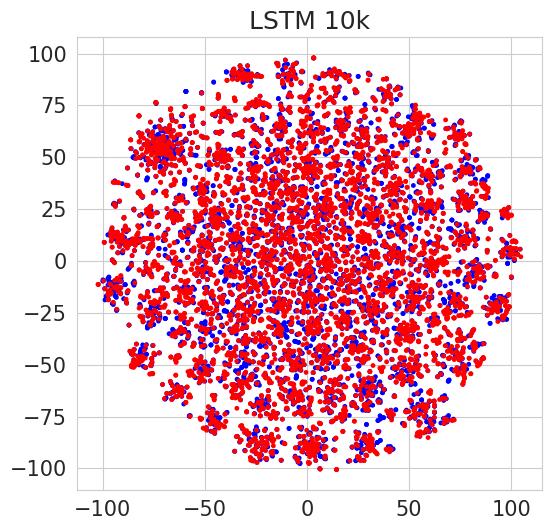

In [50]:
visualization(lstm10k, "LSTM 10k")

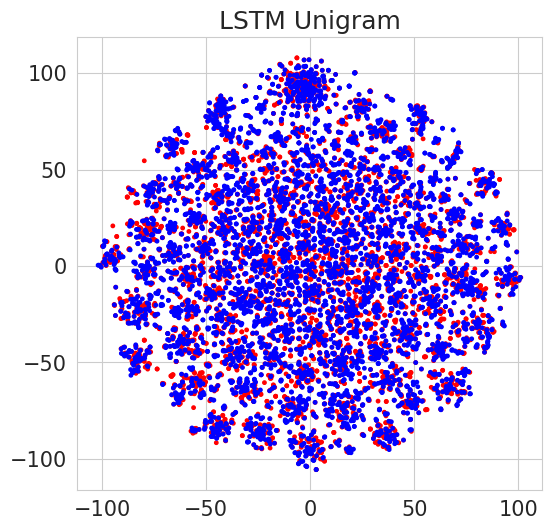

In [52]:
visualization(lstm_unigram, "LSTM Unigram")

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from datasets import load_dataset

model_id = "sberbank-ai/rugpt3small_based_on_gpt2"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

test = load_dataset("IlyaGusev/gazeta", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

In [ ]:
generated_corpus = [lstm5k.inference(prefix='') for i in range(size)]
encodings = tokenizer("\n\n".join(generated_corpus), return_tensors="pt")
encodings

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

* депутат - это когда ты не знаешь, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что я не могу понять, что ты не знаешь, что он не смог бы выйти из дома.

* вышкинец, физтеховец и мгушник самооцензнует - таблетки в городе экипательные сенсам- не давайте только кормить.
* пришёл качок в бар, а у меня в голове и запискается в задницу.
* кефтемеее это когда - в россии, а в том, что у меня есть два раза.